
# prediccion de incidentes viales en la ciudad de Medellin

## importacion librerias necesarias

In [1]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers


## lectura y exploracion de los datos

In [2]:
#lectura dataframe saltando las filas malas
df=pd.read_csv("incidentes_viales.csv",on_bad_lines='skip',index_col=False,sep=";",encoding="UTF-8")
print(df.head())

    AÑO  CBML CLASE_ACCIDENTE      DIRECCION       DIRECCION ENCASILLADA  \
0  2015  1013  Caida Ocupante    CR 46 CL 43    CR  046   043  000 00000   
1  2015  1020          Choque  CR 43 A CL 29  CR  043 A   029  000 00000   
2  2015  0205            Otro    CR 46 CL 37    CR  046   037  000 00000   
3  2015  0101       Atropello   CR 34 CL 112    CR  034   112  000 00000   
4  2015  1504          Choque    CR 50 CL 14    CR  050   014  000 00000   

         DISEÑO  EXPEDIENTE      FECHA_ACCIDENTE          FECHA_ACCIDENTES  \
0  Tramo de via  A000259731  21/10/2015 05:58:00  2015-10-21T10:58:00.000Z   
1  Tramo de via  A000261725  05/11/2015 03:00:00  2015-11-05T08:00:00.000Z   
2  Tramo de via  A000259739  21/10/2015 07:40:00  2015-10-21T12:40:00.000Z   
3  Tramo de via  A000259752  21/10/2015 12:00:00  2015-10-21T17:00:00.000Z   
4  Tramo de via  A000259949  03/11/2015 06:16:00  2015-11-03T11:16:00.000Z   

  GRAVEDAD_ACCIDENTE  MES NRO_RADICADO NUMCOMUNA                     BARRI

C:\Users\johan\anaconda3\envs\tensorflow_gpu\lib\site-packages\IPython\core\interactiveshell.py:3552: DtypeWarning: Columns (0,11) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
#revisamos las columnas
print(df.columns)
print("numero de columnas iniciales ",len(df.columns))
print("numero de filas iniciales ",df.shape[0])


Index(['AÑO', 'CBML', 'CLASE_ACCIDENTE', 'DIRECCION', 'DIRECCION ENCASILLADA',
       'DISEÑO', 'EXPEDIENTE', 'FECHA_ACCIDENTE', 'FECHA_ACCIDENTES',
       'GRAVEDAD_ACCIDENTE', 'MES', 'NRO_RADICADO', 'NUMCOMUNA', 'BARRIO',
       'COMUNA', 'LOCATION', 'X', 'Y'],
      dtype='object')
numero de columnas iniciales  18
numero de filas iniciales  270765


## limpieza de datos

In [4]:
#eliminacion de datos con nulos
df.dropna(inplace=True)
#eliminar datos duplicados
df.drop_duplicates(inplace=True)
print(df.shape[0])

250686


In [5]:
#AÑO-Año de ocurrencia del incidente
df["AÑO"]=df["AÑO"].apply(lambda x : re.findall(r"[0-9]{4}",str(x))[0])
print(df["AÑO"].unique())

['2015' '2014' '2016' '2017' '2018' '2019' '2020']


In [6]:
#CBML-Codigo catastral que corresponde al codigo comuna, barrio, manzana, lote catastral de un predio.
print(len(df["CBML"].unique()))

521


In [7]:
#CLASE_ACCIDENTE-Clasificación del IPAT sobre la clase de accidente de transito: choque, atropello, volcamiento,
#caida de ocupante, incendio, u otro (que no corresponde a las anteriores 5 clasificaciones, p. ej: sumersión)
df["CLASE_ACCIDENTE"]=df["CLASE_ACCIDENTE"].apply(lambda x : str(x).replace("Caída de Ocupante","Caida Ocupante").lower())
print((df["CLASE_ACCIDENTE"].unique()))

['caida ocupante' 'choque' 'otro' 'atropello' 'volcamiento' 'incendio']


In [8]:
#DIRECCION-Dirección donde ocurrió el incidente
##aparentemente se encuentra ya formateada
print((df["DIRECCION"].sample(10)))

52991      CR 65 CL 115
111350      CL 60 CR 74
121496      CR 65 CL 93
16190       CR 49 CL 95
230378      CR 50 CL 29
39615       CR 51 CL 78
181077    CR 70 CL 32 B
118230      CL 52 CR 49
192394      CR 57 CL 51
216182    CL 10 A CR 34
Name: DIRECCION, dtype: object


In [9]:
#DIRECCION ENCASILLADA-	Dirección encasillada que entrega el geocodificador
##aparentemente se encuentra ya formateada
##variable con poca informacion util dada la variable anterior--escoger una de las 2
print((df["DIRECCION ENCASILLADA"].sample(10)))

11885         CR  052   079  000 00000
98843         CR  065   032  000 00000
147105     CR  056  S 055 B  000 00000
3442        CR  106   034 F  000 00000
148873      CR  054   044 A  000 00000
182930     CR  050 FF S 010  000 00000
155248      CL  047 D   078  000 00000
78006         CR  063   052  000 00000
34795         CL  044   045  000 00000
11357     CR  053 BB  011 FF 000 00000
Name: DIRECCION ENCASILLADA, dtype: object


In [10]:
#DISENO-Sitio de la vía donde ocurrió el accidente: Cicloruta, Glorieta, Interseccion, Lote o Predio, Paso a Nivel, Paso Elevado,
#Paso Inferior, Pontón, Puente, Tramo de via, Tunel, Via peatonal
df["DISEÑO"]=df["DISEÑO"].apply(lambda x : str(x).replace("Pont\\xF3n","Pontón").lower())
print((df["DISEÑO"].unique()))

['tramo de via' 'interseccion' 'glorieta' 'lote o predio' 'paso a nivel'
 'puente' 'paso elevado' 'ciclo ruta' 'paso inferior' 'via peatonal'
 'pontón' 'tunel']


In [11]:
#EXPEDIENTE
#Consecutivo que asigna UNE, según el orden de llegada de los expedientes para su diligenciamiento
##variable  aprarentemente con poco valor
print((df["EXPEDIENTE"].sample(10)))

6565      A000373377
147956    A000591064
250846    A000928199
101079    A000498822
14113     A000673667
266059    A001150318
97149     A000661538
225212    A000485316
233097    A000369231
159198    A000924406
Name: EXPEDIENTE, dtype: object


In [12]:
#FECHA_ACCIDENTE
#Fecha del accidente, proviene del IPAT - Informe Policial de accidente de Tránsito
df["FECHA_ACCIDENTE"] = pd.to_datetime(df["FECHA_ACCIDENTE"],dayfirst=True)
print((df["FECHA_ACCIDENTE"].sample(10)))

173398   2019-12-20 08:50:00
252647   2019-04-07 13:15:00
152027   2016-10-20 19:30:00
18649    2018-09-21 15:30:00
90370    2015-09-01 05:40:00
125405   2017-03-21 17:15:00
16932    2018-10-24 07:20:00
232777   2016-03-04 05:10:00
257286   2019-08-03 11:30:00
11530    2016-09-14 17:50:00
Name: FECHA_ACCIDENTE, dtype: datetime64[ns]


In [13]:
#FECHA_ACCIDENTES
#Fecha de los accidente (formato YYYY-MM-DD hh:mi:ss), proviene del IPAT - Informe Policial de accidentes de Tránsito
##veriable redundante con la anterior
print((df["FECHA_ACCIDENTES"].head(10)))

0    2015-10-21T10:58:00.000Z
1    2015-11-05T08:00:00.000Z
2    2015-10-21T12:40:00.000Z
3    2015-10-21T17:00:00.000Z
4    2015-11-03T11:16:00.000Z
5    2015-11-05T09:30:00.000Z
6    2015-10-18T09:40:00.000Z
7    2015-11-04T09:46:00.000Z
8    2015-10-21T12:00:00.000Z
9    2015-11-05T12:00:00.000Z
Name: FECHA_ACCIDENTES, dtype: object


In [14]:
#GRAVEDAD_ACCIDENTE
#Clasificación del IPAT - Informe Policial de Accidentes de Tránsito, sobre la gravedad del accidente, corresponde al resultado 
#más grave presentado en el accidente. Daños materiales "Sólo daños", accidente con heridos "Herido", accidente con muertos 
#"Muerto". No indica cantidad
df["GRAVEDAD_ACCIDENTE"]=df["GRAVEDAD_ACCIDENTE"].apply(lambda x : str(x).replace("Solo da\\xF1os","Solo daños").lower())
print((df["GRAVEDAD_ACCIDENTE"].unique()))

['con heridos' 'solo daños' 'con muertos']


In [15]:
#MES
#Mes de ocurrencia del incidente vial
print((df["MES"].unique()))

[10 11 12  9  4  3  5  6  7  8  1  2]


In [16]:
#NRO_RADICADO
#Consecutivo que asigna UNE, según el orden de llegada de los expedientes para su diligenciamiento
#no tiene mucho valor aparentemente para nuestros fines
print((df["NRO_RADICADO"].head()))

0    1508668
1    1510621
2    1508691
3    1508694
4    1510634
Name: NRO_RADICADO, dtype: object


In [17]:
#NUMCOMUNA
#Numero de la comununa en la que ocurrio incidente vial
print(df["NUMCOMUNA"].unique())

['10' '02' '01' '15' '14' '11' '07' '06' '04' '09' '05' '80' '13' '08'
 '16' '03' '12' '70' '60' '90' 'In' 'SN' '0' '50' 'AU' '5' '7' '9' '4' '3'
 '1' '2' '8' '6' 'Sin Inf']


In [18]:
#BARRIO
print(len(df["BARRIO"].unique()))
#Barrio de ocurrencia del incidente vial
#ó por o
df["BARRIO"]=df["BARRIO"].apply(lambda x : str(x).lower().replace("\\xf3","o").replace("ó","o"))
#é por e 
df["BARRIO"]=df["BARRIO"].apply(lambda x : str(x).replace("\\xe9","e").replace("é","e"))
#á por a 
df["BARRIO"]=df["BARRIO"].apply(lambda x : str(x).replace("\\xc1","a").replace("\\xe1","a").replace("á","a"))
#ñ
df["BARRIO"]=df["BARRIO"].apply(lambda x : str(x).replace("\\xf1","ñ"))
#\\xed í por i
df["BARRIO"]=df["BARRIO"].apply(lambda x : str(x).replace("\\xed","i").replace("í","i"))
#\\xfa ú por u
df["BARRIO"]=df["BARRIO"].apply(lambda x : str(x).replace("\\xfa","u").replace("ú","u"))
print((df["BARRIO"].unique()))

489
['barrio colon' 'san diego' 'la francia' 'santo domingo savio no. 1'
 'santa fe' 'la florida' 'los conquistadores' 'la alpujarra' 'villa nueva'
 'facultad de minas u. nacional' 'la esperanza' 'perpetuo socorro'
 'campo valdes no. 1' 'miraflores' 'oleoducto' 'terminal de transporte'
 'gerona' 'u.d. atanasio girardot' 'alejandro echavarria'
 'cabecera san antonio de prado' 'manila' 'los balsos no.2' 'moravia'
 'tenche' 'universidad nacional' 'los colores' 'caribe'
 'juan xxiii la quiebra' 'belalcazar' 'santa cruz' 'sucre' 'la candelaria'
 'el estadio' 'suramericana' 'la gloria' 'centro administrativo'
 'las estancias' 'aures no. 2' 'los angeles' 'castilla' 'la salle'
 'la america' 'picacho' 'bosques de san pablo' 'la aguacatala'
 'playon de los comuneros' 'estacion villa' 'la colina' 'popular'
 'villa del socorro' 'cucaracho' 'santa maria de los angeles'
 'el chagualo' 'la mansion' 'san benito' 'la castellana' 'jesus nazareno'
 'loreto' 'asomadera no. 1' 'el salvador' 'cristo rey' 'm

In [19]:
#COMUNA
#Denominación con la cual se identifica cada Comuna o Corregimiento. 01:Popular 02:Santa Cruz 03:Manrique 04:Aranjuez 05:Castilla 06:Doce de Octubre 07:Robledo 08:Villa Hermosa 09:Buenos Aires 10:La Candelaria 11:Laureles - Estadio 12:La América 13:San Javier 14:El Poblado 15:Guayabal 16:Belén 50:San Sebastián de Palmitas 60:San Cristobal 70:Altavista 80:San Antonio de Prado 90:Santa Elena 99:Toda la Ciudad
##variable redundante
#ó por o
df["COMUNA"]=df["COMUNA"].apply(lambda x : str(x).lower().replace("\\xf3","o").replace("ó","o"))
#á por a 
df["COMUNA"]=df["COMUNA"].apply(lambda x : str(x).replace("\\xc1","a").replace("\\xe1","a").replace("á","a"))
#é por e 
df["COMUNA"]=df["COMUNA"].apply(lambda x : str(x).replace("\\xe9","e").replace("é","e"))
print((df["COMUNA"].unique()))

['la candelaria' 'santa cruz' 'popular' 'guayabal' 'el poblado'
 'laureles estadio' 'robledo' 'doce de octubre' 'aranjuez' 'buenos aires'
 'castilla' 'corregimiento de san antonio de prado' 'san javier'
 'villa hermosa' 'belen' 'manrique' 'la america'
 'corregimiento de altavista' 'corregimiento de san cristobal'
 'corregimiento de santa elena' 'in' 'sn'
 'corregimiento de san sebastian de palmitas' '0' 'au']


In [20]:
#LOCATION
#Fuente de información con la cual se realizó la geocodificación
print((df["LOCATION"].head(10)))

0    [-75.5688011014, 6.24312304123]
1    [-75.5693883283, 6.22870030622]
2    [-75.5503911403, 6.29869502502]
3    [-75.5442195069, 6.30019383306]
4     [-75.578180998, 6.21699243701]
5      [-75.561118009, 6.2047775959]
6    [-75.5810144962, 6.24576066323]
7    [-75.5752597216, 6.24685341912]
8    [-75.5624178534, 6.25341454089]
9    [-75.5931430393, 6.27330476643]
Name: LOCATION, dtype: object


In [21]:
#X
#Coordenada X en metros del accidente, en sistema de coordenadas MAGNA Medellin Local
print(df["X"].head(10))

0    834949.69
1    834880.17
2    837004.94
3    837688.53
4    833903.11
5    835788.30
6    833598.49
7    834235.89
8    835659.53
9    832264.64
Name: X, dtype: float64


In [22]:
#Y
#Coordenada Y en metros del accidente, en sistema de coordenadas MAGNA Medellin Local
print(df["Y"].head(10))

0    1182357.34
1    1180762.02
2    1188499.17
3    1188663.05
4    1179469.60
5    1178113.02
6    1182652.97
7    1182772.04
8    1183493.83
9    1185703.90
Name: Y, dtype: float64


In [23]:
#Eliminar duplicados
df.drop_duplicates(inplace=True)
#borrar columnas con datos redudantes o poco aportantes
df.drop(labels=["DIRECCION ENCASILLADA","EXPEDIENTE","FECHA_ACCIDENTES","NRO_RADICADO","COMUNA"],axis=1,inplace=True)

In [ ]:
df.to_csv("datosLimpios.csv")
#guardamos los datos en una nueva varible
data=df.copy()

In [ ]:
#df=pd.read_csv("datosLimpios.csv")

## 1 - Entrenamiento de un modelo predictivo
Se deberá construir un modelo que permita predecir la accidentalidad por tipo de accidente a nivel semanal, mensual y diario. Para esto se deberán considerar fechas especiales.

Sea X el con junto de parametros 

In [24]:
#seleccionamos las variables de interes dentro del df
from datetime import time
df=df[["CLASE_ACCIDENTE","FECHA_ACCIDENTE","MES"]]

df["DIA"]=df["FECHA_ACCIDENTE"].apply(lambda x: x.date())
df["SEMANA"]=df["FECHA_ACCIDENTE"].apply(lambda x: x.week)

print(df.sample(5))

       CLASE_ACCIDENTE     FECHA_ACCIDENTE  MES         DIA  SEMANA
264248          choque 2020-01-09 08:00:00    1  2020-01-09       2
241443          choque 2016-06-04 22:30:00    6  2016-06-04      22
2993            choque 2016-05-27 17:10:00    5  2016-05-27      21
188924          choque 2018-11-23 07:50:00   11  2018-11-23      47
87250           choque 2017-02-20 15:20:00    2  2017-02-20       8


In [25]:
dia=df.copy()
aux= dia.set_index(pd.Index(dia["DIA"].values))["DIA"].groupby(level=0).count()
accidentes_por_dia=pd.DataFrame()
accidentes_por_dia["dia"] =aux.index
accidentes_por_dia["cantidad"] =aux.values
accidentes_por_dia["dia_de_la_semana"]=accidentes_por_dia["dia"].apply(lambda x : pd.Timestamp(x).day_of_week)
accidentes_por_dia["semana_del_año"]=accidentes_por_dia["dia"].apply(lambda x : pd.Timestamp(x).week)
accidentes_por_dia["dia_del_mes"]=accidentes_por_dia["dia"].apply(lambda x : pd.Timestamp(x).day)
accidentes_por_dia["año"]=accidentes_por_dia["dia"].apply(lambda x : pd.Timestamp(x).year)
accidentes_por_dia["mes"]=accidentes_por_dia["dia"].apply(lambda x : pd.Timestamp(x).month)
#agrgar dias feriados
print((accidentes_por_dia.head()))
aux= dia.set_index(pd.Index(dia["DIA"].values))["DIA"].groupby(level=0)
print(aux)

          dia  cantidad  dia_de_la_semana  semana_del_año  dia_del_mes   año  \
0  2014-07-04        22                 4              27            4  2014   
1  2014-07-05       116                 5              27            5  2014   
2  2014-07-06        76                 6              27            6  2014   
3  2014-07-07       164                 0              28            7  2014   
4  2014-07-08       118                 1              28            8  2014   

   mes  
0    7  
1    7  
2    7  
3    7  
4    7  


In [ ]:
!pip install holidays_co

In [26]:
import holidays_co as co
from datetime import timedelta
#dia_festivo 1 si 0 no
accidentes_por_dia["dia_festivo"]=accidentes_por_dia["dia"].apply(lambda x : int(co.is_holiday_date(x)))
#sigiente_dia_festivo
accidentes_por_dia["sigiente_dia_festivo"]=accidentes_por_dia["dia"].apply(lambda x : int(co.is_holiday_date(x+timedelta(days=1))))
#anterior_dia_festivo
accidentes_por_dia["anterior_dia_festivo"]=accidentes_por_dia["dia"].apply(lambda x : int(co.is_holiday_date(x-timedelta(days=1))))
accidentes_por_dia.tail(10)

,dia,cantidad,dia_de_la_semana,semana_del_año,dia_del_mes,año,mes,dia_festivo,sigiente_dia_festivo,anterior_dia_festivo
2241,2020-08-22,66,5,34,22,2020,8,0,0,0
2242,2020-08-23,42,6,34,23,2020,8,0,0,0
2243,2020-08-24,106,0,35,24,2020,8,0,0,0
2244,2020-08-25,68,1,35,25,2020,8,0,0,0
2245,2020-08-26,89,2,35,26,2020,8,0,0,0
2246,2020-08-27,82,3,35,27,2020,8,0,0,0
2247,2020-08-28,109,4,35,28,2020,8,0,0,0
2248,2020-08-29,96,5,35,29,2020,8,0,0,0
2249,2020-08-30,61,6,35,30,2020,8,0,0,0
2250,2020-08-31,91,0,36,31,2020,8,0,0,0


### Entrenamiento y validación
Los modelos predictivos se deberán construir con los datos de los años 2014, 2015, 2016, 2018. Se usan los accidentes del año 2019 y 2020 (¡alerta!) para validar los modelos.
Se deberá analizar el comportamiento del modelo predictivo en los años 2021 y 2022 y explicar las posibles desviaciones.

In [27]:
accidentes_por_dia.pop("dia")

0       2014-07-04
1       2014-07-05
2       2014-07-06
3       2014-07-07
4       2014-07-08
           ...    
2246    2020-08-27
2247    2020-08-28
2248    2020-08-29
2249    2020-08-30
2250    2020-08-31
Name: dia, Length: 2251, dtype: object

In [28]:
train_dataset=accidentes_por_dia[accidentes_por_dia["año"]<2019]
test_dataset = accidentes_por_dia.drop(train_dataset.index)

In [29]:
train_stats = train_dataset.describe()
train_stats.pop("cantidad")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
dia_de_la_semana,1642.0,3.001827,2.001674,0.0,1.0,3.0,5.0,6.0
semana_del_año,1642.0,28.037150,15.028811,1.0,15.0,29.0,41.0,53.0
dia_del_mes,1642.0,15.766748,8.797251,1.0,8.0,16.0,23.0,31.0
año,1642.0,2016.224117,1.313578,2014.0,2015.0,2016.0,2017.0,2018.0
mes,1642.0,6.855055,3.434732,1.0,4.0,7.0,10.0,12.0
dia_festivo,1642.0,0.048721,0.215350,0.0,0.0,0.0,0.0,1.0
sigiente_dia_festivo,1642.0,0.049330,0.216622,0.0,0.0,0.0,0.0,1.0
anterior_dia_festivo,1642.0,0.048721,0.215350,0.0,0.0,0.0,0.0,1.0


In [30]:
train_labels = train_dataset.pop('cantidad')
test_labels = test_dataset.pop('cantidad')

In [31]:
#normalizamos la data
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']


normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

Construyamos nuestro modelo. Aquí, utilizaremos un modelo secuencial con dos capas ocultas densamente conectadas y una capa de salida que devuelve un único valor continuo. Los pasos de construcción del modelo se envuelven en una función, build_model, ya que crearemos un segundo modelo, más adelante.
https://www.tensorflow.org/tutorials/keras/regression#construye_el_modelo

In [67]:
def build_model():
  model = keras.Sequential([
    layers.Dense(32, activation='relu',input_dim=8, input_shape=[len(train_dataset.keys())]),
    layers.Dense(16, activation='relu'),
    layers.Dense(8, activation='relu'),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(1)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

In [68]:
model = build_model()
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_29 (Dense)            (None, 32)                288       
                                                                 
 dense_30 (Dense)            (None, 16)                528       
                                                                 
 dense_31 (Dense)            (None, 8)                 136       
                                                                 
 dense_32 (Dense)            (None, 1)                 9         
                                                                 
Total params: 961
Trainable params: 961
Non-trainable params: 0
_________________________________________________________________


In [69]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

array([[-0.0612832 ],
       [-0.10645219],
       [-0.17086312],
       [-0.05966241],
       [-0.00572544],
       [ 0.00819253],
       [-0.03395067],
       [-0.09506665],
       [-0.2011531 ],
       [-0.2911995 ]], dtype=float32)

In [70]:
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 1000

history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

In [63]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,accuracy,val_loss,val_mae,val_mse,val_accuracy,epoch
995,239.841614,11.880177,239.841614,0.0,293.167419,13.166054,293.167419,0.0,995
996,238.227478,11.886980,238.227478,0.0,401.956482,15.959504,401.956482,0.0,996
997,239.862366,11.872177,239.862366,0.0,421.173096,16.603506,421.173096,0.0,997
998,240.908600,11.896194,240.908600,0.0,274.634033,12.608550,274.634033,0.0,998
999,238.487335,11.799675,238.487335,0.0,358.380646,14.970199,358.380646,0.0,999


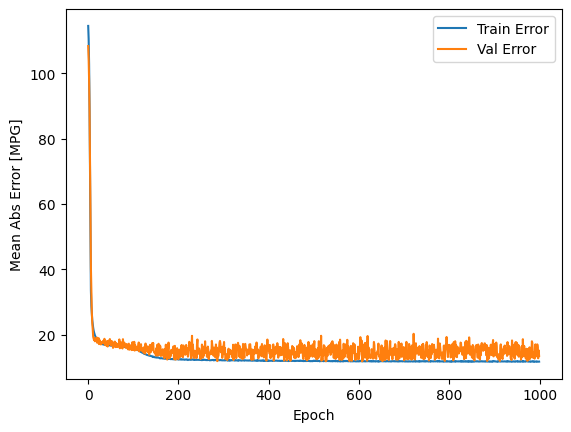

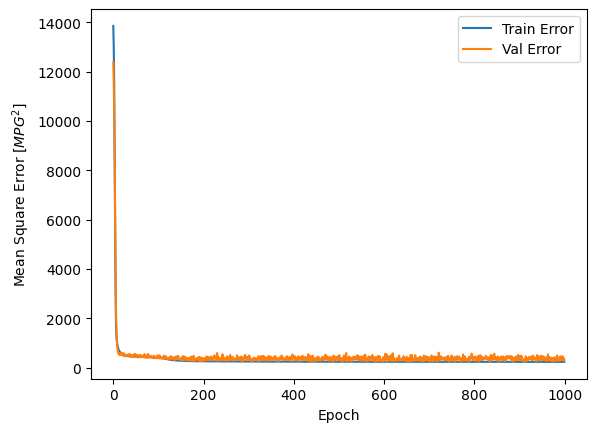

In [52]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MPG]')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  #plt.ylim([0,5])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MPG^2$]')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
  #plt.ylim([0,20])
  plt.legend()
  plt.show()


plot_history(history)

In [ ]:
model = build_model()

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])

plot_history(history)